# Анализ оттока клиентов сети фитнес-центров «Культурист-датасаентист»

## Содержание

1. [Исследовательский анализ данных.](#EDA)

2. [Модель прогнозирования оттока клиентов.](#model)

3. [Кластеризация клиентов.](#clustering)

4. [Выводы.](#end)

**Задача**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Необходимо провести анализ и подготовить план действий по удержанию клиентов.

**План работы**

- проверка и обработка датасета;
- анализ предоставленных данных;
- создание модели прогнозирования оттока клиентов:
    - на основе логистической регрессии;
    - на основе случайного леса;
    - определение лучшей модели.
- кластеризация клиентов;
- выводы.

**Результат**

- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;

    2) предложить меры по снижению оттока;

    3) определить другие особенности взаимодействия с клиентами.

## Исследовательский анализ данных <a id="EDA"></a> 

Переданные данные содержат информацию на месяц до оттока и факт оттока на определённый месяц.

**Данные клиента за предыдущий до проверки факта оттока месяц:**
- `'gender'` — пол;

- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;

- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

- `'Phone'` — наличие контактного телефона;

- `'Age'` — возраст;

- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);

- `'Group_visits'` — факт посещения групповых занятий;

- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;

- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;

- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

- `'Churn'` — факт оттока в текущем месяце.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

import warnings

In [2]:
warnings.filterwarnings("ignore")

### Оценка датасета и предобработка данных

In [3]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
# функция для оценки необходимости предобработки данных
def describe(data):
    print(data.shape)
    display(data.head())
    print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
    print(data.info())
    print('\033[1m' + 'Количество пропусков' + '\033[0m')
    print(data.isnull().sum())
    print('\033[1m' + 'Количество дубликатов' + '\033[0m')
    print(data.duplicated().sum())
    print('\033[1m' + 'Описание датафрейма' + '\033[0m')
    print(data.describe())

In [5]:
describe(data)

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total       

In [6]:
# приведем названия столбцов к нижнему регистру
data.columns = [x.lower() for x in data.columns]

In [7]:
def shapiro(value_1, value_2, value_3):
    alpha = 0.05  # критический уровень статистической значимости
    
    results = st.shapiro(value_1)
    p_value = results[
        1
    ]  # второе значение в массиве результатов (с индексом 1) - p-value
    
    print('\033[1m' + 'Суммарная выручка от дополнительных услуг' + '\033[0m')
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
        
    results = st.shapiro(value_2)
    p_value = results[
        1
    ]  # второе значение в массиве результатов (с индексом 1) - p-value
    print()
    print('\033[1m' + 'Средняя частота посещений в неделю за все время действия абонемента' + '\033[0m')
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
        
    results = st.shapiro(value_3)
    p_value = results[
        1
    ]  # второе значение в массиве результатов (с индексом 1) - p-value
    print()
    print('\033[1m' + 'Средняя частота посещений в неделю за последний месяц' + '\033[0m')
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [8]:
# функция для построения гистрограмм числовых признаков
def histograms(
    first_chart, 
    second_chart, 
    third_chart, 
    fourth_chart, 
    fifth_chart
):
    plt.figure(figsize=(20,10))
    
    ax1 = plt.subplot(2, 3, 1)
    first_chart.hist(ax=ax1, bins=50)
    plt.xlabel('Суммарная выручка')
    plt.ylabel('Количество клиентов')
    plt.title('Cуммарная выручка от дополнительных услуг фитнес-центра')
    
    ax2 = plt.subplot(2, 3, 2)
    second_chart.hist(ax=ax2, bins=50)
    plt.xlabel('Среднее число посещений в неделю')
    plt.ylabel('Количество клиентов')
    plt.title('Средняя частота посещений в неделю за все время с начала действия абонемента')
    
    ax3 = plt.subplot(2, 3, 3)
    third_chart.hist(ax=ax3, bins=50)
    plt.xlabel('Среднее число посещений в неделю за предыдущий месяц')
    plt.ylabel('Количество клиентов')
    plt.title('Средняя частота посещений в неделю за предыдущий месяц')
    
    ax4 = plt.subplot(2, 3, 4)
    fourth_chart.hist(ax=ax4, bins=20)
    plt.xlabel('Количество месяцев')
    plt.ylabel('Количество клиентов')
    plt.title('Количество месяцев до окончания текущего действующего абонемента')
    
    ax5 = plt.subplot(2, 3, 5)
    fifth_chart.hist(ax=ax5, bins=20)
    plt.xlabel('Количество месяцев')
    plt.ylabel('Количество клиентов')
    plt.title('Время с момента первого обращения в фитнес-центр')
        
    plt.tight_layout()
    plt.show()

Проверим распределения в числовых признаках, используя метод Шапиро-Уилка. За нулевую гипотезу принимаем, что распределение нормально.

In [9]:
# вызовем функцию, чтобы оценить распределение в числовых признаках
shapiro(
    data['avg_additional_charges_total'], 
    data['avg_class_frequency_total'], 
    data['avg_class_frequency_current_month']
)

Суммарная выручка от дополнительных услуг
p-значение:  8.672956247203068e-31
Отвергаем нулевую гипотезу: распределение не нормально

Средняя частота посещений в неделю за все время действия абонемента
p-значение:  5.726042673326846e-15
Отвергаем нулевую гипотезу: распределение не нормально

Средняя частота посещений в неделю за последний месяц
p-значение:  7.524450663520925e-22
Отвергаем нулевую гипотезу: распределение не нормально


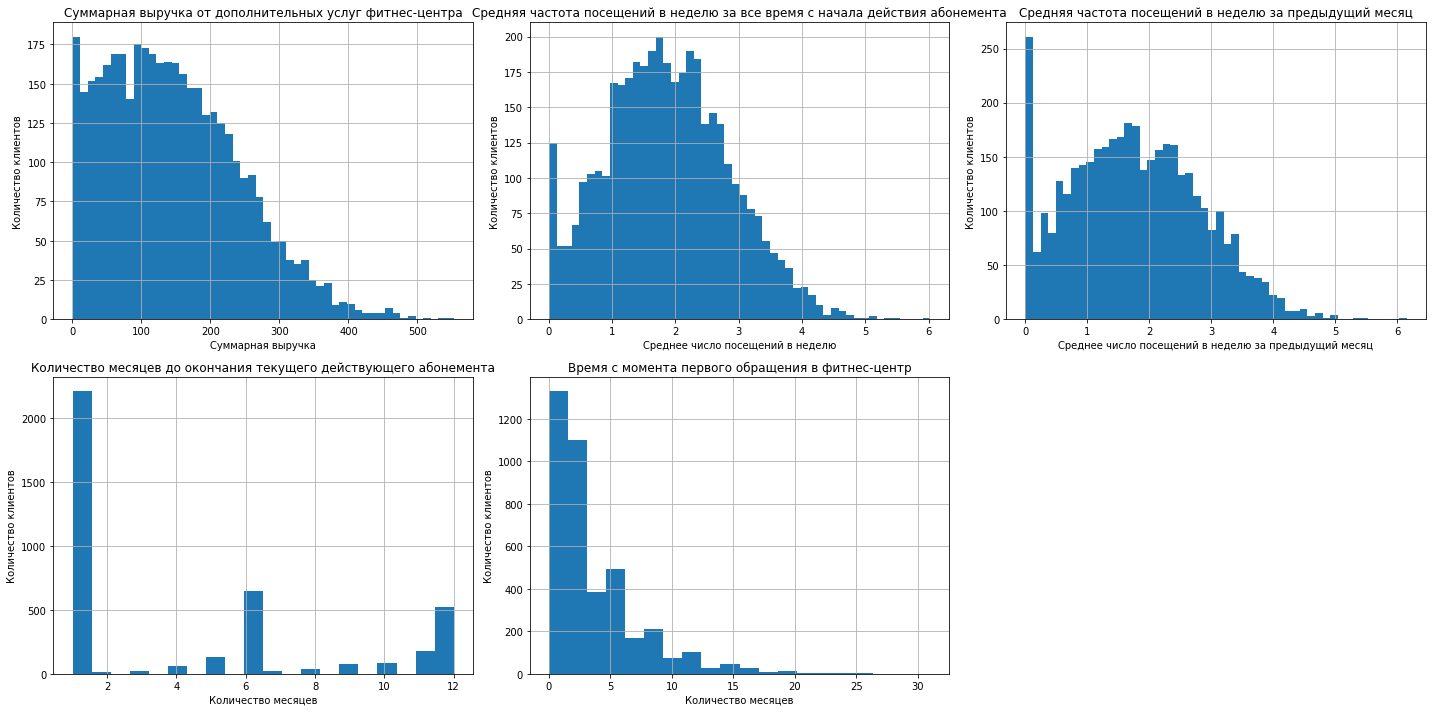

In [10]:
# вызовем функцию, чтобы построить гистограммы
histograms(
    data['avg_additional_charges_total'], 
    data['avg_class_frequency_total'], 
    data['avg_class_frequency_current_month'], 
    data['month_to_end_contract'], 
    data['lifetime']
)

В предоставленном датасете содержится информация о 4000 клиентов — это достаточный объем данных для построения модели. 

Датасет полный, пропусков и дубликатов не обнаружено. Аномальных значений не выявлено. Скорректировано написание названий столбцов.

Присутствуют категориальне данные в столбцах:
- 'gender';

- 'Near_Location';

- 'Partner';

- Promo_friends;

- 'Phone';

- 'Group_visits';

- 'Churn'.

Привязки к дате в данном случае нет.

**Показатели**

75% клиентов фитнес-центра покупает абонементы на срок до полугода.

Средний возраст клиента — 29 лет. Самым юным клиентам 18 лет, максимальный возраст — 41 год.

Среди клиентов из представленного датасета первое посещение фитнес-центра состоялось в среднем 3 месяца назад, 75% клиентов пользуются услугами этой сети не дольше 5 месяцев.

За неделю в среднем клиенты посещают фитнес-центр 1-2 раза, средние показатели за неделю и за предыдущий месяц отличаются не сильно.

Большинство клиентов проживает рядом с фитнес-центром.

Порядка 25% пришли по партнерским программам, и столько же — в рамках акции "приведи друга".

Не более 25% клиентов ходят на групповые занятия.

Отток составляет не более 30% — причины рассмотрим далее.

**Распределение**

Гистограммы, построенные по трем числовым признакам — выручка, средняя частота посещений в неделю и средняя частота посещений в неделю за прошлый месяц, демонстрируют ненормальное распределение за счет большого количества нулевых значений. 

Гистограммы, отражающие количество месяцев до окончания срока действия абонемента и с момента первого посещения, также показывают ненормальное распределение. Мы видим, что наибольшее число клиентов использует месячный абонемент.

Можно отметить увеличение числа новых клиентов — сеть привлекает все больше людей.

### Анализ оттока клиентов

In [11]:
# посмотрим на средние показатели для групп оттока и оставшихся клиентов
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [12]:
# сформируем таблицы по признаку оттока
data_gone = data.query('churn == 1')
data_remain = data.query('churn == 0')

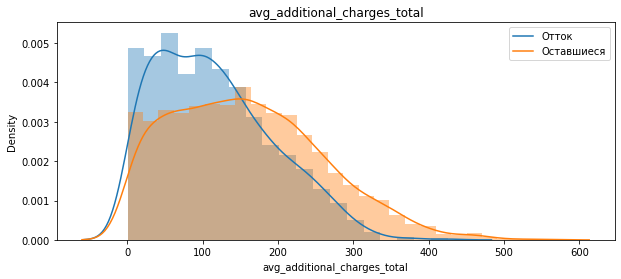

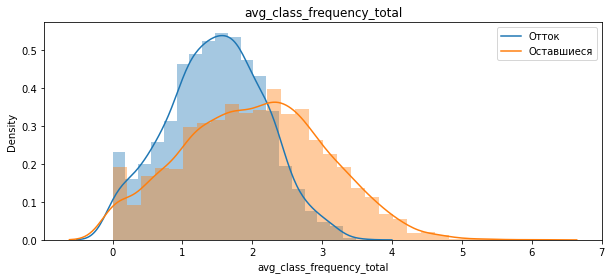

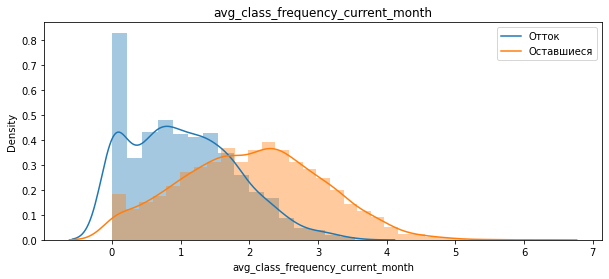

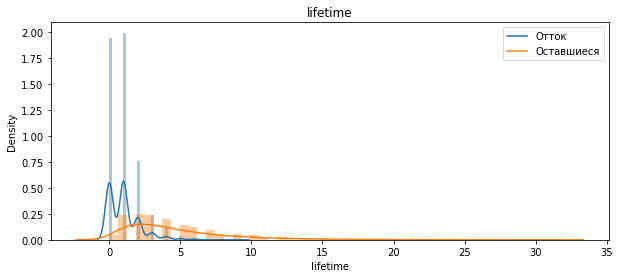

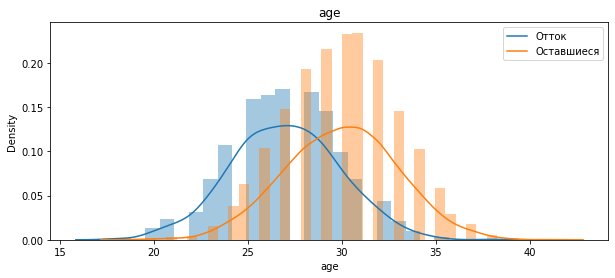

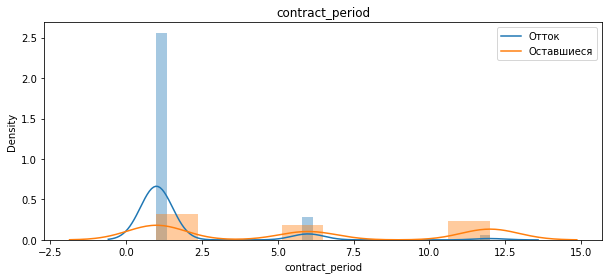

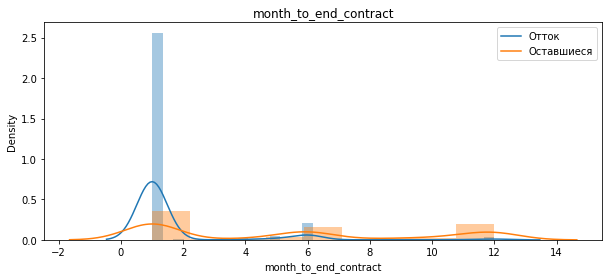

In [13]:
# сформируем список с названиями нужных колонок
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
# нарисуем графики
for column in distplot_columns: 
    plt.figure(figsize=(10,4))
    plt.title(column)
    sns.distplot(data_gone[column])
    sns.distplot(data_remain[column])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.show()

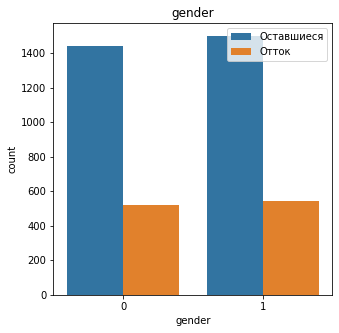

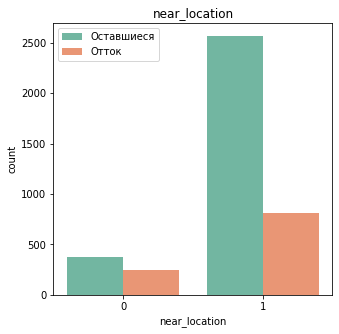

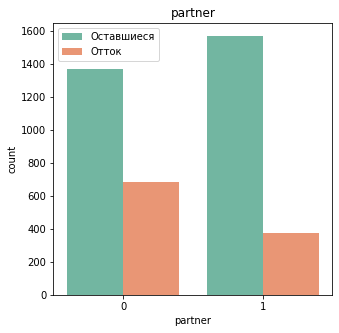

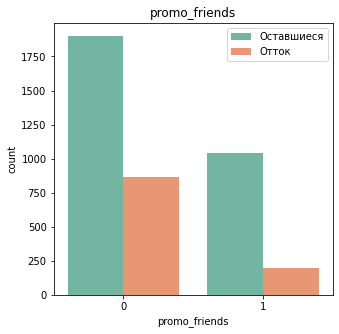

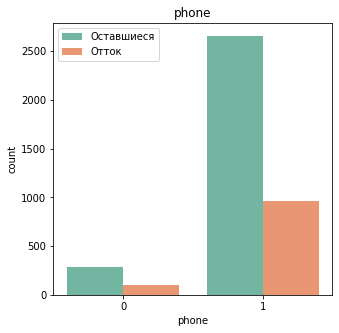

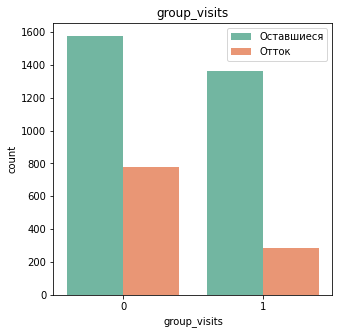

In [14]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='churn', data=data)
    sns.set_palette('Set2')
    plt.title(column)
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

**Распределение в зависимости от поведения клиента**

Для клиентов, переставших посещать фитнес-центр, характерно:

- чаще покупают абонемент на месяц;
- средний возраст — около 27 лет;
- в среднем посещают фитнес-центр раз в неделю;
- большая часть из них перестает ходить практически сразу после покупки абонемента;
- очень редко посещают коллективные занятия.

Для клиентов, не прекративших посещать фитнес-центр, характерно:

- чаще покупают абонементы на полгода и год;
- средний возраст — около 30 лет;
- в среднем посещают фитнес-центр два раза в неделю;
- большая часть появились в фитнес-центре 2-3 раза за последний месяц;
- чаще ушедших клиентов записываются на коллективные занятия;
- живут недалеко от фитнес-центра;
- являются сотрудниками организаций-партнеров.

Акция "приведи друга" заметно сокращает отток клиентов.

Пол, наличие в анкете телефона для связи не оказывают существенного влияния.

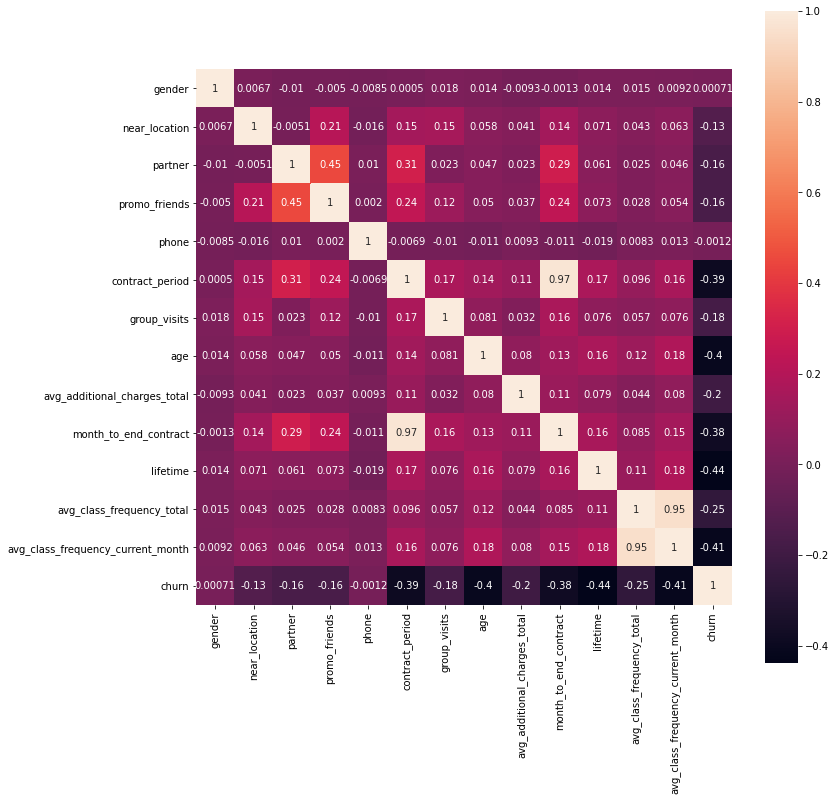

In [15]:
# построим и изобразим в виде heatmap матрицу корреляций
cm = data.corr() # вычисляем матрицу корреляций

# рисуем heatmap
plt.figure(figsize = (12,12))
sns.heatmap(cm, square = True, annot = True)

plt.show()

С целевой переменной — факт оттока — ярко выраженной корреляции нет ни у одного признака.

Имеются мультиколлинеарные признаки — contract_period и month_to_end_contact, avg_class_frequency_current_month и avg_class_frequency_total.

## Модель прогнозирования оттока клиентов <a id="model"></a> 

In [18]:
# разделяем модель на обучающую и валидационную выборки, проводим стратификацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# задаем алгоритм логистической регрессии для модели
lr_model = LogisticRegression(solver='liblinear')

# обучаем модель
lr_model.fit(X_train, y_train)

# делаем прогнозы
lr_predictions = lr_model.predict(X_test)

print('\033[1m' + 'Модель, обученная логистической регрессией' + '\033[0m')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

# задаем алгоритм на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучаем модель
rf_model.fit(X_train, y_train)

# делаем прогнозы
rf_predictions = rf_model.predict(X_test)

print()
print('\033[1m' + 'Модель, обученная случайным лесом' + '\033[0m')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Модель, обученная логистической регрессией
Accuracy: 0.90
Precision: 0.83
Recall: 0.80

Модель, обученная случайным лесом
Accuracy: 0.89
Precision: 0.81
Recall: 0.79


Модель, обученная алгоритмом логистической регрессии, показала себя лучше, чем обученная случайным лесом.

## Кластеризация клиентов <a id="clustering"></a> 

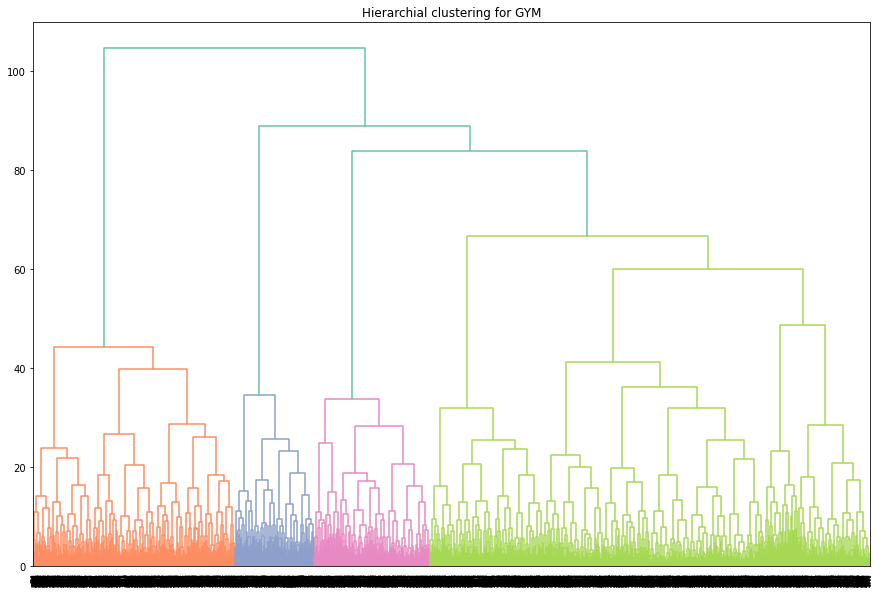

In [19]:
# проводим стандартизацию и формируем матрицу расстояний
scaler = StandardScaler()
x_sc = scaler.fit_transform(data.drop(columns = ['churn']))

# строим дендрограмму
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

Мы видим, что оптимальное количество кластеров — 4, но в дальнейшей работе будем использовать 5 в соответствии с ТЗ.

In [20]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в дополнительный столбец датасета
data['cluster_km'] = labels

# выводим статистику по средним значениям признаков по кластеру
# отсортируем сразу по столбцу churn от меньшего к большему
display(data.groupby('cluster_km').mean().sort_values(by = 'churn'))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263


In [21]:
#посмотрим на численность кластеров
data.cluster_km.value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster_km, dtype: int64

Самый многочисленный у нас 3-й кластер, он же лидирует по оттоку (51,4%). На втором месте по численности 0-й кластер, но он же самый стабильный — отток у него минимальный (2,7%). На третьем месте по численности 4-й кластер, который также имеет небольшой отток (6,8%).

Мы видим, что самые "преданные" клиенты фитнес-центра живут или работают недалеко от него, являются сотрудниками компании-партнера или пришли по акции "приведи друга", их возраст 29-30 лет, они занимаются регулярно 1-3 раза в неделю и примерно половина из них посещает групповые занятия.

In [22]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(data, x_name, y_name, cluster_name):
    plt.figure(figsize = (5,5))
    sns.scatterplot(data[x_name], data[y_name],
           hue = data[cluster_name], palette = 'Paired', alpha = 0.4
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

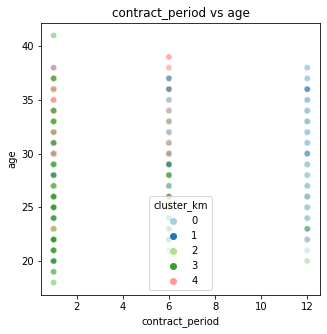

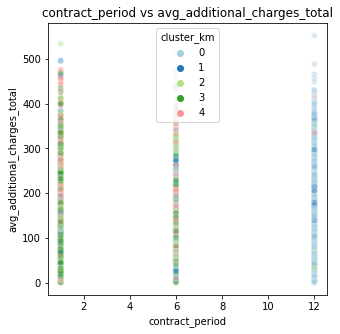

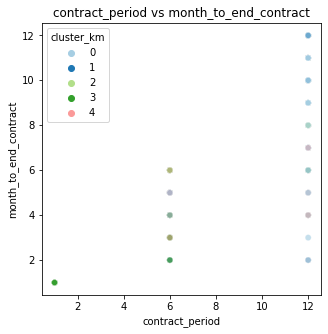

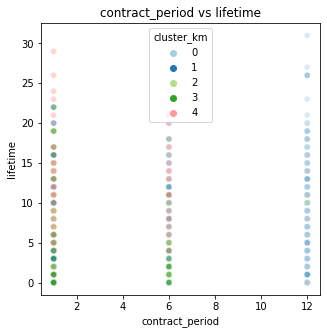

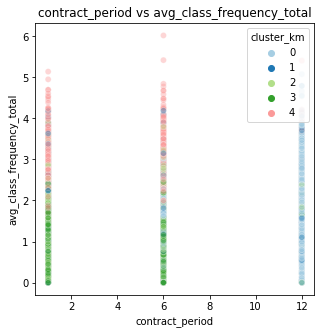

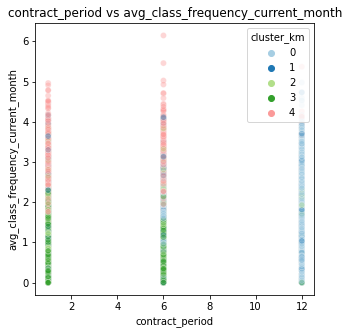

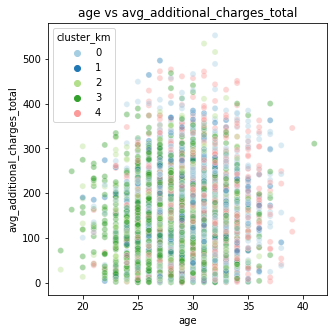

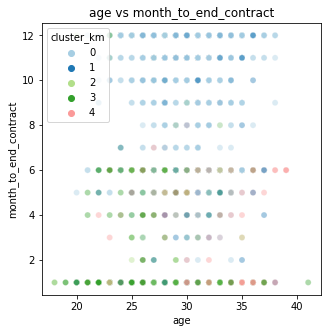

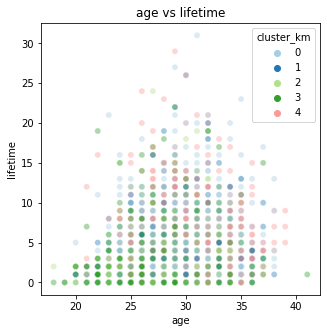

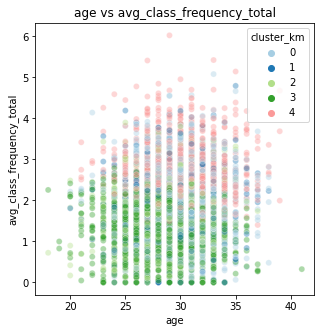

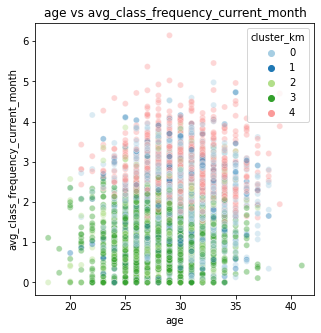

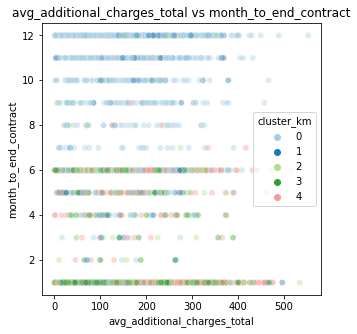

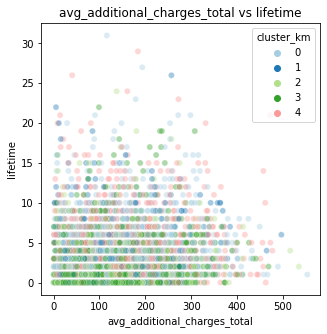

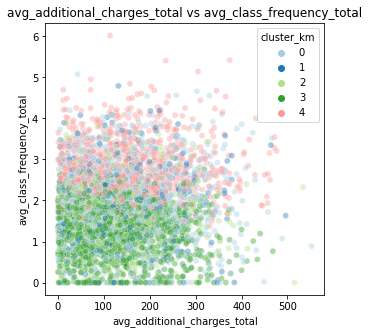

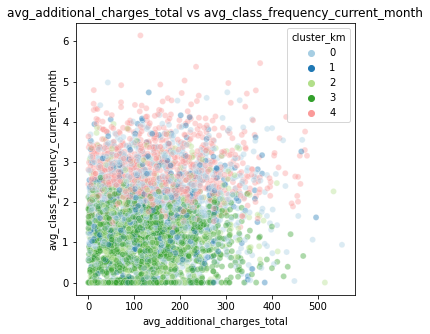

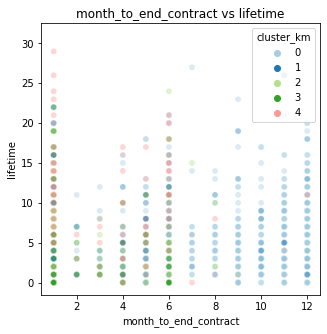

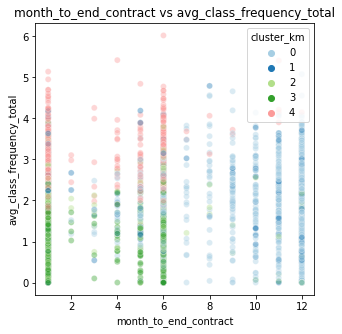

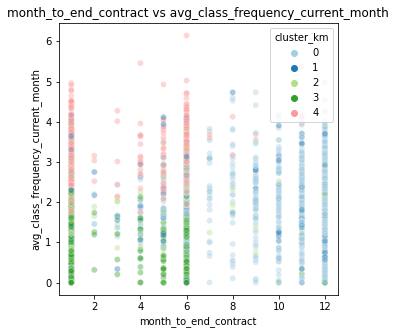

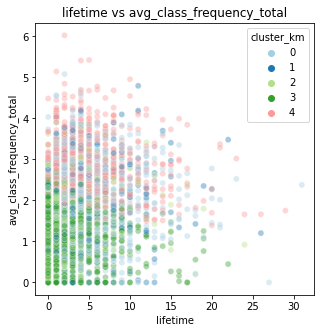

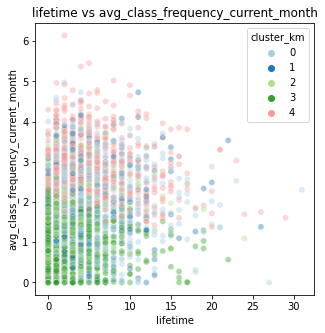

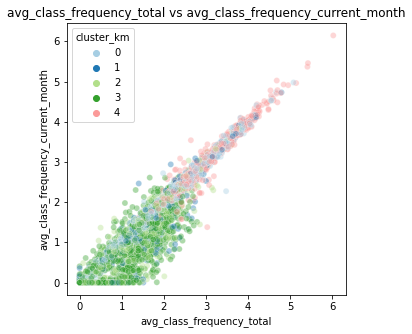

In [23]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам, исключив бинарные признаки
col_pairs = list(itertools.combinations(data.drop(['cluster_km', 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn'], axis=1).columns, 2))

for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

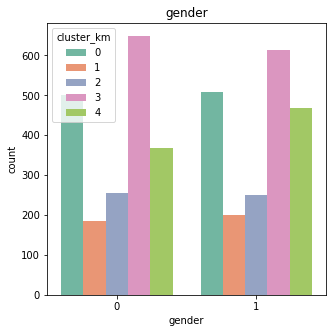

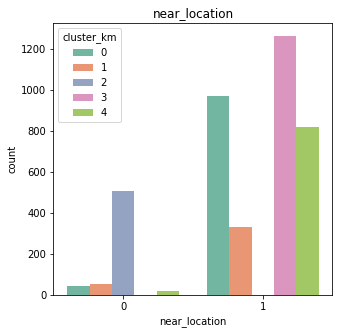

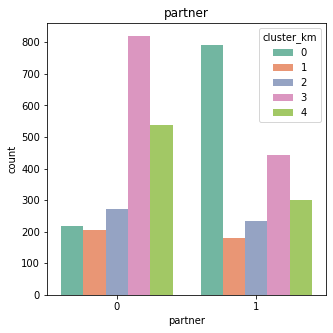

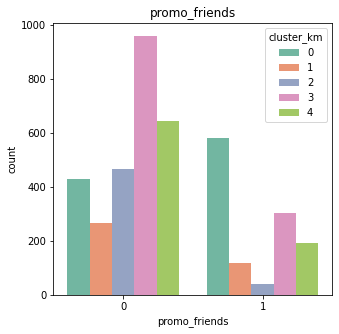

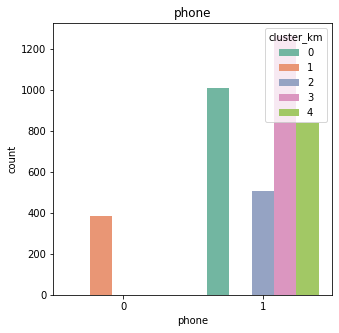

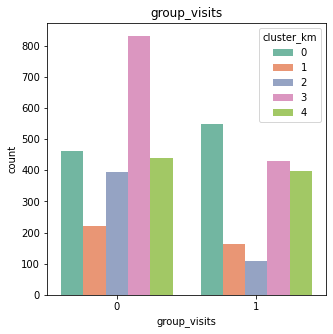

In [24]:
# построим countplot-графики для бинарных признаков
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='cluster_km', data=data)
    plt.title(column)
    plt.show()

Клиенты до 20 лет не приобретают долгосрочные абонементы, так же, как и клиенты 40+.

Чем моложе клиенты, тем, в основном, меньше они тратят на дополнительные услуги фитнес-центра, а также имеют меньший жизненный цикл.

Клиенты из второго и третьего кластера в неделю занимаются реже, чем клиенты из других кластеров.

Мы видим, что пол не оказывает влияния на отток.

Работа или проживание рядом с фитнес-центром важны — третий кластер, имеющий наибольшее число далеко проживающих/работающих клиентов, показывает отток гораздо более высокий, чем первые два кластера. Но тем не менее, третий кластер, имеющий наибольший отток, включает в себя клиентов, проживающих рядом с центром. В этом случае явно играют роль иные признаки.

Сотрудники компаний-партнеров гораздо лояльнее к сети, активно ей пользуются. То же можно сказать и про клиентов, пришедших в рамках акции «приведи друга».

Наличие или отсутствие номера телефона мало на что влияет — большинство групп указывают номер.

Меньше всех в посещении групповых занятий заинтересованы кластеры три и два, они же имеют наибольший отток.

## Выводы <a id="end"></a> 

По результатам анализа можно выделить несколько групп клиентов фитнес-центра:

1. Наиболее лояльная группа, имеющая наименьший отток (нулевой кластер, 1010 клиентов, отток — 2,7%) — люди 29-30 лет, проживающие или работающие поблизости от фитнес-центра, являющиеся сотрудниками компании-партнера или пришедшие по акции «приведи друга». Они чаще приобретают абонементы на полгода и более, приходят регулярно 1-2 раза в неделю, больше половины таких клиентов участвуют в групповых занятиях, тратят больше денег на дополнительные услуги фитнес-центра. Средний жизненный цикл этих клиентов 4-5 месяцев.

2. Вторая по лояльности группа (четвертый кластер, 838 клиентов, отток — 6,8%) похожа на первую, но они не являются сотрудниками компаний-партнеров и гораздо реже приходят по акции «приведи друга». Эти клиенты покупают абонементы не дольше чем на полгода, чаще — на месяц, но при этом среднее количество посещений в неделю у них выше, чем у первой группы, и тратят на дополнительные услуги фитнес-центра они немного больше. Средний жизненный цикл — 4-5 месяцев, показатель чуть выше, чем у первой группы.

3. Третья группа (первый кластер, 385 клиентов, отток — 26,7%) близка по портрету клиента к двум предыдущим — здесь выше процент работников компаний-партнеров и пришедших по акции, чем у второй группы, но живут или работают они дальше от фитнес-центра. Эти клиенты по какой-то причине не оставляют свой номер телефона, чаще берут полугодовые абонементы. 42% посещают групповые занятия. Ходят так же 1-2 раза в неделю довольно регулярно, тратят на дополнительные услуги меньше первых двух групп. Жизненный цикл — 3-4 месяца.

4. Четвертая группа (второй кластер, 505 клиентов, отток — 44,3%) заметно «моложе» предыдущих групп, проживает или работает не рядом с фитнес-центром, из-за чего среди них почти нет приглашенных по акции, но тем не менее высокий процент работников компаний-партнеров (46%). Покупают абонементы не более чем на полгода, в основном предпочитают месячные абонементы, не любят групповые занятия, тратят на дополнительные услуги заметно меньше предыдущих групп, ходят 1-2 раза в неделю, но по показателю посещений в неделю за предыдущий месяц можно сделать вывод, что постепенно регулярность посещений падает. Жизненный цикл таких клиентов невелик — 2-3 месяца.

5. Пятая группа (третий кластер, 1262 клиента, отток — 51,4%) — самая «молодая» группа, в основном до 28 лет. Проживают или работают рядом с фитнес-центром, но чаще всего не являются приглашенными по акции и не связаны с компаниями-партнерами. Почти не покупают абонементы дольше месяца, только 34% клиентов посещают групповые занятия, тратят меньше всех остальных групп на дополнительные услуги. Ходят в основном раз в неделю, регулярность посещений постепенно снижается. Жизненный цикл — 2,5 месяца.


**Рекомендации**

`Первая группа` стабильная, но забывать про нее не стоит — для поддержания лояльности этих клиентов можно сформировать программу, включающую в качестве поощрения за использование долговременных программ бесплатные пробные дополнительные услуги центра, обновлять и дополнять спектр этих услуг, чтобы заинтересовывать больше посетителей. 

`Вторая группа` клиентов при довольно большом жизненном цикле и высокой регулярности посещений почему-то предпочитает пользоваться месячными абонементами. Этих клиентов стоит изучить лучше, чтобы понять, почему они делают такой выбор. Возможно, они боятся вкладываться в более долгосрочный абонемент из-за особенностей работы или по причине личного осторожного отношения, тогда фитнес-центру необходимы какие-то более гибкие условия по «заморозке» имеющихся абонементов или дополнительных условий для работников компаний-партнеров, чья деятельность, например, связана с частыми разъездами, чтобы клиенты не боялись использовать долгосрочные предложения. Этим клиентам также, вероятно, будут интересны расширенные индивидуальные программы с тренером, так как они готовы больше вкладываться в свое здоровье как финансово, так и в плане времени, плюс — это самая "старшая" группа, которой, возможно, необходимо составление индивидуального плана тренировок в связи с особенностями здоровья.

`Третья группа` довольно активно посещает групповые занятия, но так как проживают/работают они дальше, чем предыдущие группы, возможно, им пригодились бы занятия после 18:30, чтобы было время добраться до фитнес-центра. Но важно учитывать, что это самая малочисленная группа, а процент оттока средний — возможно, затраты на его снижение себя не окупят.

`Четвертая группа` также невелика, при этом проживает/работает далеко от фитнес-центра. Эти клиенты довольно часто являются сотрудниками компаний-партнеров, где, скорее всего, рассказывают о возможности посещать этот фитнес-центр, но необходимость тратить лишние время и силы на дорогу до него быстро уничтожит мотивацию заниматься.  Удержать этих клиентов будет наиболее трудно, и вряд ли целесообразно вкладывать в это ресурсы, если только сеть не планирует расширяться и открыть где-то еще несколько дополнительных центров, которые, возможно, станут более удобными для клиентов этой группы.

`Пятая группа`, возможно, в силу более молодого возраста легкомысленнее относится к занятиям спортом: ходят всего лишь раз в неделю, нерегулярно, быстро бросают. Отдельной проблемой для юных посетителей может быть стоимость абонемента и отсутствие интересных программ, что объясняет низкий интерес к групповым занятиям. Для снижения оттока таких клиентов можно порекомендовать добавить в расписание группы каких-либо активных современных видов спорта, интересных более молодой группе посетителей, а также продумать специальные предложения для молодежи, чей заработок еще не позволяет оплатить сразу долгосрочный абонемент.